In [1]:
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import sys
import numpy as np

Using TensorFlow backend.


In [0]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(2048))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 2, 2
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        #gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.568369, acc.: 50.00%] [G loss: 0.389034]


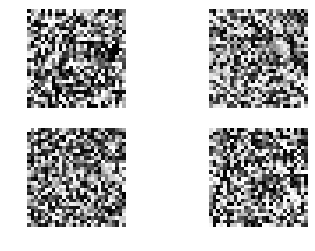

1 [D loss: 0.743181, acc.: 50.00%] [G loss: 0.446891]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2 [D loss: 0.487005, acc.: 59.38%] [G loss: 0.559496]
3 [D loss: 0.400041, acc.: 73.44%] [G loss: 0.693331]
4 [D loss: 0.318315, acc.: 89.06%] [G loss: 0.817252]
5 [D loss: 0.303407, acc.: 90.62%] [G loss: 0.915221]
6 [D loss: 0.261892, acc.: 95.31%] [G loss: 1.132202]
7 [D loss: 0.231965, acc.: 95.31%] [G loss: 1.205476]
8 [D loss: 0.212029, acc.: 96.88%] [G loss: 1.260366]
9 [D loss: 0.172545, acc.: 100.00%] [G loss: 1.446658]
10 [D loss: 0.178006, acc.: 98.44%] [G loss: 1.493535]
11 [D loss: 0.166979, acc.: 100.00%] [G loss: 1.661478]
12 [D loss: 0.119049, acc.: 100.00%] [G loss: 1.778885]
13 [D loss: 0.115689, acc.: 100.00%] [G loss: 1.768002]
14 [D loss: 0.111435, acc.: 100.00%] [G loss: 1.865546]
15 [D loss: 0.091215, acc.: 100.00%] [G loss: 1.956177]
16 [D loss: 0.094386, acc.: 100.00%] [G loss: 2.106892]
17 [D loss: 0.077651, acc.: 100.00%] [G loss: 2.067159]
18 [D loss: 0.074141, acc.: 100.00%] [G loss: 2.168723]
19 [D loss: 0.068358, acc.: 100.00%] [G loss: 2.187671]
20 [D lo

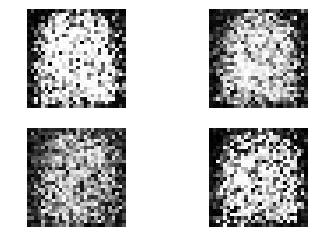

201 [D loss: 0.300196, acc.: 92.19%] [G loss: 3.903753]
202 [D loss: 0.434649, acc.: 78.12%] [G loss: 2.946788]
203 [D loss: 0.654686, acc.: 78.12%] [G loss: 3.785430]
204 [D loss: 0.763030, acc.: 65.62%] [G loss: 2.490461]
205 [D loss: 0.417935, acc.: 82.81%] [G loss: 3.002565]
206 [D loss: 0.528384, acc.: 78.12%] [G loss: 3.340504]
207 [D loss: 0.400253, acc.: 84.38%] [G loss: 3.012297]
208 [D loss: 0.188589, acc.: 95.31%] [G loss: 3.206648]
209 [D loss: 0.303907, acc.: 89.06%] [G loss: 2.927852]
210 [D loss: 0.341841, acc.: 92.19%] [G loss: 3.010036]
211 [D loss: 0.514274, acc.: 79.69%] [G loss: 2.421613]
212 [D loss: 0.380469, acc.: 82.81%] [G loss: 2.480175]
213 [D loss: 0.720920, acc.: 65.62%] [G loss: 3.065408]
214 [D loss: 0.448236, acc.: 78.12%] [G loss: 2.856421]
215 [D loss: 0.477627, acc.: 81.25%] [G loss: 2.306262]
216 [D loss: 0.312255, acc.: 90.62%] [G loss: 2.782635]
217 [D loss: 0.657962, acc.: 67.19%] [G loss: 2.345537]
218 [D loss: 0.551239, acc.: 76.56%] [G loss: 2.

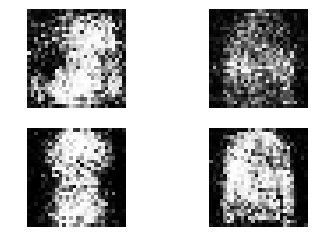

401 [D loss: 0.657950, acc.: 65.62%] [G loss: 1.039603]
402 [D loss: 0.671631, acc.: 62.50%] [G loss: 0.999732]
403 [D loss: 0.671585, acc.: 56.25%] [G loss: 1.055263]
404 [D loss: 0.630934, acc.: 60.94%] [G loss: 0.972991]
405 [D loss: 0.707566, acc.: 60.94%] [G loss: 0.897563]
406 [D loss: 0.532511, acc.: 76.56%] [G loss: 1.015484]
407 [D loss: 0.670007, acc.: 59.38%] [G loss: 1.101649]
408 [D loss: 0.611252, acc.: 65.62%] [G loss: 1.075959]
409 [D loss: 0.680418, acc.: 60.94%] [G loss: 0.958097]
410 [D loss: 0.636228, acc.: 59.38%] [G loss: 1.026663]
411 [D loss: 0.566594, acc.: 76.56%] [G loss: 0.998366]
412 [D loss: 0.562474, acc.: 75.00%] [G loss: 1.072300]
413 [D loss: 0.565103, acc.: 73.44%] [G loss: 1.079869]
414 [D loss: 0.554191, acc.: 76.56%] [G loss: 1.079837]
415 [D loss: 0.735286, acc.: 59.38%] [G loss: 0.934347]
416 [D loss: 0.585557, acc.: 71.88%] [G loss: 1.065133]
417 [D loss: 0.629807, acc.: 62.50%] [G loss: 1.009948]
418 [D loss: 0.583974, acc.: 64.06%] [G loss: 1.

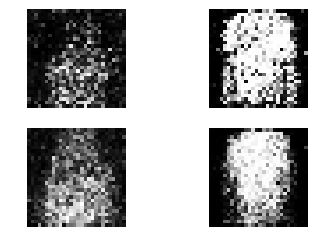

601 [D loss: 0.567014, acc.: 70.31%] [G loss: 1.019770]
602 [D loss: 0.556042, acc.: 76.56%] [G loss: 1.034747]
603 [D loss: 0.524721, acc.: 73.44%] [G loss: 0.956635]
604 [D loss: 0.521234, acc.: 75.00%] [G loss: 1.130611]
605 [D loss: 0.590566, acc.: 64.06%] [G loss: 1.154164]
606 [D loss: 0.606019, acc.: 65.62%] [G loss: 1.010603]
607 [D loss: 0.564435, acc.: 76.56%] [G loss: 1.080362]
608 [D loss: 0.627153, acc.: 64.06%] [G loss: 1.057503]
609 [D loss: 0.618179, acc.: 71.88%] [G loss: 1.000729]
610 [D loss: 0.590271, acc.: 67.19%] [G loss: 1.058013]
611 [D loss: 0.601075, acc.: 76.56%] [G loss: 1.148992]
612 [D loss: 0.511739, acc.: 79.69%] [G loss: 1.051752]
613 [D loss: 0.579660, acc.: 71.88%] [G loss: 1.084829]
614 [D loss: 0.592959, acc.: 65.62%] [G loss: 1.009095]
615 [D loss: 0.625677, acc.: 62.50%] [G loss: 1.056443]
616 [D loss: 0.616533, acc.: 65.62%] [G loss: 1.102083]
617 [D loss: 0.571407, acc.: 71.88%] [G loss: 1.011721]
618 [D loss: 0.586714, acc.: 62.50%] [G loss: 1.

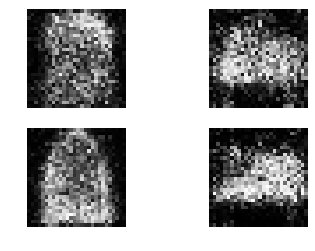

801 [D loss: 0.621460, acc.: 65.62%] [G loss: 0.959304]
802 [D loss: 0.606607, acc.: 70.31%] [G loss: 0.914482]
803 [D loss: 0.616455, acc.: 67.19%] [G loss: 0.843928]
804 [D loss: 0.619670, acc.: 67.19%] [G loss: 0.909307]
805 [D loss: 0.662582, acc.: 62.50%] [G loss: 0.892914]
806 [D loss: 0.623970, acc.: 65.62%] [G loss: 0.955398]
807 [D loss: 0.688100, acc.: 62.50%] [G loss: 0.844722]
808 [D loss: 0.563345, acc.: 73.44%] [G loss: 0.898883]
809 [D loss: 0.587348, acc.: 71.88%] [G loss: 0.905938]
810 [D loss: 0.547964, acc.: 75.00%] [G loss: 0.905197]
811 [D loss: 0.706584, acc.: 65.62%] [G loss: 0.973840]
812 [D loss: 0.639148, acc.: 65.62%] [G loss: 1.025005]
813 [D loss: 0.669563, acc.: 62.50%] [G loss: 0.945058]
814 [D loss: 0.609570, acc.: 65.62%] [G loss: 0.952522]
815 [D loss: 0.638163, acc.: 60.94%] [G loss: 0.944256]
816 [D loss: 0.590887, acc.: 67.19%] [G loss: 0.945502]
817 [D loss: 0.724411, acc.: 48.44%] [G loss: 0.826126]
818 [D loss: 0.592634, acc.: 70.31%] [G loss: 0.

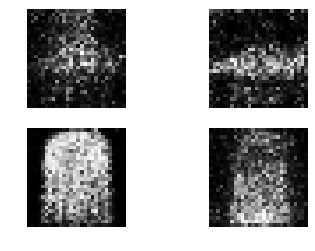

1001 [D loss: 0.627253, acc.: 65.62%] [G loss: 0.851430]
1002 [D loss: 0.615491, acc.: 68.75%] [G loss: 0.814401]
1003 [D loss: 0.674428, acc.: 54.69%] [G loss: 0.792729]
1004 [D loss: 0.664418, acc.: 59.38%] [G loss: 0.813591]
1005 [D loss: 0.658714, acc.: 57.81%] [G loss: 0.889262]
1006 [D loss: 0.638583, acc.: 68.75%] [G loss: 1.008555]
1007 [D loss: 0.721645, acc.: 50.00%] [G loss: 0.843607]
1008 [D loss: 0.683971, acc.: 59.38%] [G loss: 0.858762]
1009 [D loss: 0.628242, acc.: 60.94%] [G loss: 0.868571]
1010 [D loss: 0.646278, acc.: 59.38%] [G loss: 0.861506]
1011 [D loss: 0.623054, acc.: 68.75%] [G loss: 0.890734]
1012 [D loss: 0.659975, acc.: 59.38%] [G loss: 0.891186]
1013 [D loss: 0.678292, acc.: 56.25%] [G loss: 0.891115]
1014 [D loss: 0.678649, acc.: 59.38%] [G loss: 0.857042]
1015 [D loss: 0.596789, acc.: 70.31%] [G loss: 0.871513]
1016 [D loss: 0.541742, acc.: 73.44%] [G loss: 0.818062]
1017 [D loss: 0.635616, acc.: 64.06%] [G loss: 0.856562]
1018 [D loss: 0.673033, acc.: 5

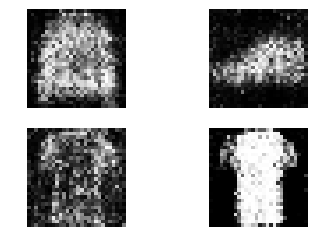

1201 [D loss: 0.668667, acc.: 56.25%] [G loss: 0.798892]
1202 [D loss: 0.598513, acc.: 75.00%] [G loss: 0.834107]
1203 [D loss: 0.637594, acc.: 62.50%] [G loss: 0.747260]
1204 [D loss: 0.656768, acc.: 59.38%] [G loss: 0.838882]
1205 [D loss: 0.673275, acc.: 53.12%] [G loss: 0.822724]
1206 [D loss: 0.669719, acc.: 57.81%] [G loss: 0.801371]
1207 [D loss: 0.682634, acc.: 54.69%] [G loss: 0.789974]
1208 [D loss: 0.637858, acc.: 67.19%] [G loss: 0.829166]
1209 [D loss: 0.620316, acc.: 67.19%] [G loss: 0.908028]
1210 [D loss: 0.632101, acc.: 67.19%] [G loss: 0.879583]
1211 [D loss: 0.683933, acc.: 53.12%] [G loss: 0.913824]
1212 [D loss: 0.652431, acc.: 62.50%] [G loss: 0.869663]
1213 [D loss: 0.600307, acc.: 70.31%] [G loss: 0.826006]
1214 [D loss: 0.586499, acc.: 67.19%] [G loss: 0.795113]
1215 [D loss: 0.629955, acc.: 67.19%] [G loss: 0.855911]
1216 [D loss: 0.614346, acc.: 67.19%] [G loss: 0.824549]
1217 [D loss: 0.630059, acc.: 65.62%] [G loss: 0.902824]
1218 [D loss: 0.589284, acc.: 6

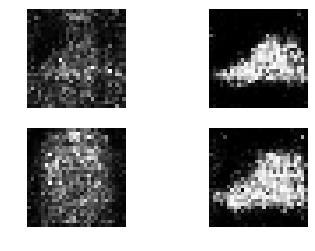

1401 [D loss: 0.600809, acc.: 70.31%] [G loss: 0.957719]
1402 [D loss: 0.643725, acc.: 68.75%] [G loss: 0.899322]
1403 [D loss: 0.708102, acc.: 51.56%] [G loss: 0.808422]
1404 [D loss: 0.675234, acc.: 60.94%] [G loss: 0.870139]
1405 [D loss: 0.615892, acc.: 65.62%] [G loss: 0.856859]
1406 [D loss: 0.652700, acc.: 59.38%] [G loss: 0.859468]
1407 [D loss: 0.607770, acc.: 60.94%] [G loss: 0.904619]
1408 [D loss: 0.598775, acc.: 60.94%] [G loss: 0.903883]
1409 [D loss: 0.615099, acc.: 71.88%] [G loss: 0.887397]
1410 [D loss: 0.666179, acc.: 59.38%] [G loss: 0.891997]
1411 [D loss: 0.663639, acc.: 57.81%] [G loss: 0.888000]
1412 [D loss: 0.672260, acc.: 57.81%] [G loss: 0.807956]
1413 [D loss: 0.692899, acc.: 48.44%] [G loss: 0.885647]
1414 [D loss: 0.701502, acc.: 62.50%] [G loss: 0.888620]
1415 [D loss: 0.630480, acc.: 64.06%] [G loss: 0.809093]
1416 [D loss: 0.630093, acc.: 65.62%] [G loss: 0.860728]
1417 [D loss: 0.671389, acc.: 56.25%] [G loss: 0.831901]
1418 [D loss: 0.623562, acc.: 7

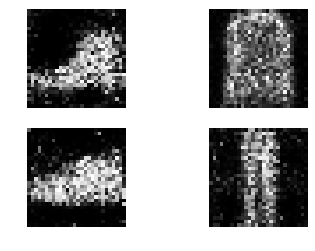

1601 [D loss: 0.608867, acc.: 60.94%] [G loss: 0.936448]
1602 [D loss: 0.641300, acc.: 62.50%] [G loss: 0.914129]
1603 [D loss: 0.711835, acc.: 51.56%] [G loss: 0.942854]
1604 [D loss: 0.613401, acc.: 70.31%] [G loss: 0.877510]
1605 [D loss: 0.658937, acc.: 57.81%] [G loss: 0.821684]
1606 [D loss: 0.619801, acc.: 67.19%] [G loss: 0.885222]
1607 [D loss: 0.609099, acc.: 68.75%] [G loss: 0.844994]
1608 [D loss: 0.650289, acc.: 64.06%] [G loss: 0.863134]
1609 [D loss: 0.637061, acc.: 64.06%] [G loss: 0.864417]
1610 [D loss: 0.643175, acc.: 62.50%] [G loss: 0.913040]
1611 [D loss: 0.600478, acc.: 65.62%] [G loss: 0.869162]
1612 [D loss: 0.592376, acc.: 75.00%] [G loss: 0.962737]
1613 [D loss: 0.627800, acc.: 60.94%] [G loss: 0.801050]
1614 [D loss: 0.638200, acc.: 65.62%] [G loss: 0.854543]
1615 [D loss: 0.636335, acc.: 68.75%] [G loss: 0.906451]
1616 [D loss: 0.601054, acc.: 68.75%] [G loss: 0.901699]
1617 [D loss: 0.587912, acc.: 71.88%] [G loss: 0.906870]
1618 [D loss: 0.682703, acc.: 5

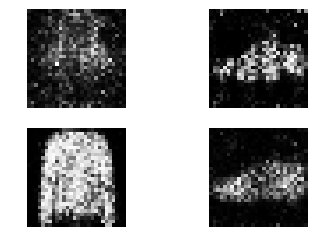

1801 [D loss: 0.619828, acc.: 62.50%] [G loss: 0.957880]
1802 [D loss: 0.637112, acc.: 60.94%] [G loss: 0.981684]
1803 [D loss: 0.610171, acc.: 73.44%] [G loss: 0.871768]
1804 [D loss: 0.585819, acc.: 68.75%] [G loss: 0.930243]
1805 [D loss: 0.657209, acc.: 59.38%] [G loss: 0.883208]
1806 [D loss: 0.617745, acc.: 67.19%] [G loss: 0.868738]
1807 [D loss: 0.643247, acc.: 60.94%] [G loss: 0.960455]
1808 [D loss: 0.634442, acc.: 65.62%] [G loss: 0.888465]
1809 [D loss: 0.660613, acc.: 56.25%] [G loss: 0.857246]
1810 [D loss: 0.688394, acc.: 48.44%] [G loss: 0.836666]
1811 [D loss: 0.618354, acc.: 60.94%] [G loss: 0.900628]
1812 [D loss: 0.598067, acc.: 68.75%] [G loss: 0.816306]
1813 [D loss: 0.617624, acc.: 65.62%] [G loss: 0.911881]
1814 [D loss: 0.682165, acc.: 59.38%] [G loss: 0.889509]
1815 [D loss: 0.566630, acc.: 75.00%] [G loss: 0.954091]
1816 [D loss: 0.708627, acc.: 51.56%] [G loss: 0.825791]
1817 [D loss: 0.629857, acc.: 70.31%] [G loss: 0.943075]
1818 [D loss: 0.608411, acc.: 6

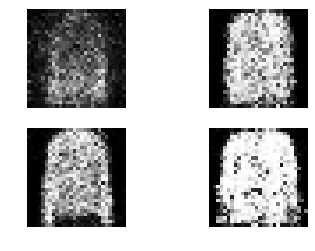

2001 [D loss: 0.589274, acc.: 67.19%] [G loss: 0.934803]
2002 [D loss: 0.610929, acc.: 71.88%] [G loss: 0.923992]
2003 [D loss: 0.616861, acc.: 60.94%] [G loss: 0.941022]
2004 [D loss: 0.627543, acc.: 64.06%] [G loss: 0.981468]
2005 [D loss: 0.642655, acc.: 59.38%] [G loss: 0.912190]
2006 [D loss: 0.673160, acc.: 62.50%] [G loss: 0.926896]
2007 [D loss: 0.611533, acc.: 64.06%] [G loss: 0.897646]
2008 [D loss: 0.618308, acc.: 65.62%] [G loss: 0.889654]
2009 [D loss: 0.604673, acc.: 68.75%] [G loss: 0.909598]
2010 [D loss: 0.537744, acc.: 71.88%] [G loss: 0.921883]
2011 [D loss: 0.591605, acc.: 70.31%] [G loss: 0.939372]
2012 [D loss: 0.638778, acc.: 59.38%] [G loss: 0.926026]
2013 [D loss: 0.583301, acc.: 68.75%] [G loss: 0.980907]
2014 [D loss: 0.619387, acc.: 64.06%] [G loss: 0.905788]
2015 [D loss: 0.660221, acc.: 57.81%] [G loss: 0.978507]
2016 [D loss: 0.596915, acc.: 76.56%] [G loss: 0.959284]
2017 [D loss: 0.678492, acc.: 53.12%] [G loss: 0.917034]
2018 [D loss: 0.539280, acc.: 7

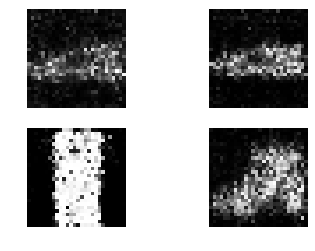

2201 [D loss: 0.607799, acc.: 68.75%] [G loss: 0.945975]
2202 [D loss: 0.439991, acc.: 87.50%] [G loss: 1.015918]
2203 [D loss: 0.716074, acc.: 50.00%] [G loss: 0.951852]
2204 [D loss: 0.655334, acc.: 54.69%] [G loss: 0.965183]
2205 [D loss: 0.512930, acc.: 82.81%] [G loss: 1.071069]
2206 [D loss: 0.662272, acc.: 59.38%] [G loss: 0.917040]
2207 [D loss: 0.655992, acc.: 59.38%] [G loss: 0.980224]
2208 [D loss: 0.633139, acc.: 67.19%] [G loss: 0.944183]
2209 [D loss: 0.600106, acc.: 60.94%] [G loss: 0.939337]
2210 [D loss: 0.669119, acc.: 51.56%] [G loss: 0.896619]
2211 [D loss: 0.584413, acc.: 68.75%] [G loss: 0.897558]
2212 [D loss: 0.645436, acc.: 64.06%] [G loss: 0.965920]
2213 [D loss: 0.668619, acc.: 56.25%] [G loss: 0.872398]
2214 [D loss: 0.553089, acc.: 76.56%] [G loss: 0.938385]
2215 [D loss: 0.629298, acc.: 59.38%] [G loss: 0.933449]
2216 [D loss: 0.638982, acc.: 54.69%] [G loss: 0.921303]
2217 [D loss: 0.693567, acc.: 57.81%] [G loss: 0.865817]
2218 [D loss: 0.620556, acc.: 6

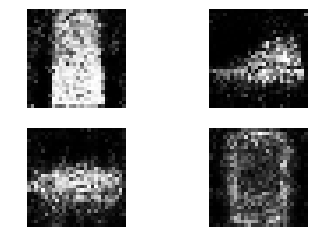

2401 [D loss: 0.631903, acc.: 67.19%] [G loss: 0.958949]
2402 [D loss: 0.610727, acc.: 68.75%] [G loss: 0.829521]
2403 [D loss: 0.648811, acc.: 54.69%] [G loss: 0.888910]
2404 [D loss: 0.655438, acc.: 60.94%] [G loss: 0.891283]
2405 [D loss: 0.686919, acc.: 56.25%] [G loss: 0.967261]
2406 [D loss: 0.622564, acc.: 65.62%] [G loss: 0.883699]
2407 [D loss: 0.685900, acc.: 51.56%] [G loss: 0.854247]
2408 [D loss: 0.617667, acc.: 62.50%] [G loss: 0.913639]
2409 [D loss: 0.658932, acc.: 60.94%] [G loss: 0.937928]
2410 [D loss: 0.592911, acc.: 64.06%] [G loss: 0.908469]
2411 [D loss: 0.617344, acc.: 71.88%] [G loss: 0.908021]
2412 [D loss: 0.620671, acc.: 62.50%] [G loss: 0.879039]
2413 [D loss: 0.700264, acc.: 50.00%] [G loss: 0.894273]
2414 [D loss: 0.693307, acc.: 54.69%] [G loss: 0.939546]
2415 [D loss: 0.677497, acc.: 57.81%] [G loss: 0.782868]
2416 [D loss: 0.661685, acc.: 53.12%] [G loss: 0.798352]
2417 [D loss: 0.640030, acc.: 65.62%] [G loss: 0.945904]
2418 [D loss: 0.633612, acc.: 6

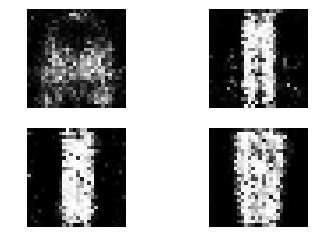

2601 [D loss: 0.669291, acc.: 53.12%] [G loss: 0.814265]
2602 [D loss: 0.678323, acc.: 53.12%] [G loss: 0.739040]
2603 [D loss: 0.614249, acc.: 57.81%] [G loss: 0.968370]
2604 [D loss: 0.570772, acc.: 70.31%] [G loss: 0.934658]
2605 [D loss: 0.660543, acc.: 65.62%] [G loss: 0.882051]
2606 [D loss: 0.647246, acc.: 60.94%] [G loss: 0.897127]
2607 [D loss: 0.638709, acc.: 67.19%] [G loss: 0.895149]
2608 [D loss: 0.674277, acc.: 57.81%] [G loss: 0.915450]
2609 [D loss: 0.678519, acc.: 59.38%] [G loss: 0.860889]
2610 [D loss: 0.644869, acc.: 64.06%] [G loss: 0.987675]
2611 [D loss: 0.634543, acc.: 67.19%] [G loss: 0.801425]
2612 [D loss: 0.650679, acc.: 62.50%] [G loss: 0.833983]
2613 [D loss: 0.602718, acc.: 73.44%] [G loss: 0.803033]
2614 [D loss: 0.631661, acc.: 67.19%] [G loss: 0.895815]
2615 [D loss: 0.624567, acc.: 65.62%] [G loss: 0.888940]
2616 [D loss: 0.614521, acc.: 60.94%] [G loss: 0.919853]
2617 [D loss: 0.585436, acc.: 70.31%] [G loss: 0.887574]
2618 [D loss: 0.736892, acc.: 5

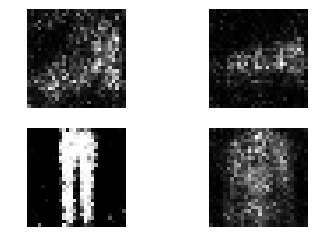

2801 [D loss: 0.691770, acc.: 57.81%] [G loss: 0.926886]
2802 [D loss: 0.635121, acc.: 70.31%] [G loss: 0.915399]
2803 [D loss: 0.663380, acc.: 67.19%] [G loss: 0.915190]
2804 [D loss: 0.636173, acc.: 59.38%] [G loss: 0.939613]
2805 [D loss: 0.632681, acc.: 68.75%] [G loss: 0.926402]
2806 [D loss: 0.596318, acc.: 67.19%] [G loss: 0.909225]
2807 [D loss: 0.716097, acc.: 57.81%] [G loss: 0.911377]
2808 [D loss: 0.690050, acc.: 59.38%] [G loss: 0.896644]
2809 [D loss: 0.607908, acc.: 67.19%] [G loss: 0.920150]
2810 [D loss: 0.614440, acc.: 59.38%] [G loss: 0.870937]
2811 [D loss: 0.696275, acc.: 57.81%] [G loss: 0.941694]
2812 [D loss: 0.664791, acc.: 60.94%] [G loss: 0.857827]
2813 [D loss: 0.692257, acc.: 59.38%] [G loss: 0.822940]
2814 [D loss: 0.599132, acc.: 70.31%] [G loss: 0.886996]
2815 [D loss: 0.682381, acc.: 64.06%] [G loss: 0.887265]
2816 [D loss: 0.666112, acc.: 60.94%] [G loss: 0.895458]
2817 [D loss: 0.674458, acc.: 59.38%] [G loss: 0.867948]
2818 [D loss: 0.620885, acc.: 6

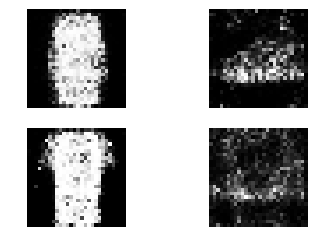

3001 [D loss: 0.699179, acc.: 54.69%] [G loss: 0.898480]
3002 [D loss: 0.639926, acc.: 59.38%] [G loss: 1.004046]
3003 [D loss: 0.667337, acc.: 54.69%] [G loss: 0.919552]
3004 [D loss: 0.638596, acc.: 65.62%] [G loss: 0.922835]
3005 [D loss: 0.634384, acc.: 64.06%] [G loss: 0.828675]
3006 [D loss: 0.600463, acc.: 62.50%] [G loss: 0.904188]
3007 [D loss: 0.602611, acc.: 62.50%] [G loss: 0.887498]
3008 [D loss: 0.694606, acc.: 59.38%] [G loss: 0.889799]
3009 [D loss: 0.666962, acc.: 59.38%] [G loss: 0.815155]
3010 [D loss: 0.606199, acc.: 70.31%] [G loss: 0.838757]
3011 [D loss: 0.646267, acc.: 62.50%] [G loss: 0.821914]
3012 [D loss: 0.590800, acc.: 73.44%] [G loss: 0.866369]
3013 [D loss: 0.611182, acc.: 64.06%] [G loss: 0.880435]
3014 [D loss: 0.652487, acc.: 56.25%] [G loss: 0.892178]
3015 [D loss: 0.708613, acc.: 60.94%] [G loss: 0.980350]
3016 [D loss: 0.637424, acc.: 62.50%] [G loss: 1.071761]
3017 [D loss: 0.644362, acc.: 64.06%] [G loss: 0.946560]
3018 [D loss: 0.649022, acc.: 5

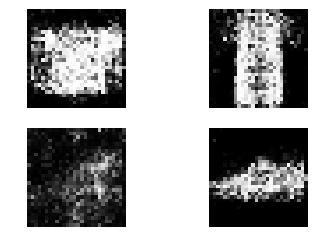

3201 [D loss: 0.692934, acc.: 59.38%] [G loss: 0.787601]
3202 [D loss: 0.648574, acc.: 57.81%] [G loss: 0.926882]
3203 [D loss: 0.597003, acc.: 75.00%] [G loss: 0.917724]
3204 [D loss: 0.641598, acc.: 59.38%] [G loss: 0.866885]
3205 [D loss: 0.611049, acc.: 64.06%] [G loss: 0.955447]
3206 [D loss: 0.698780, acc.: 53.12%] [G loss: 0.903068]
3207 [D loss: 0.740212, acc.: 50.00%] [G loss: 0.829556]
3208 [D loss: 0.627903, acc.: 57.81%] [G loss: 0.916053]
3209 [D loss: 0.668842, acc.: 59.38%] [G loss: 0.886678]
3210 [D loss: 0.609981, acc.: 62.50%] [G loss: 0.875010]
3211 [D loss: 0.622868, acc.: 65.62%] [G loss: 0.912840]
3212 [D loss: 0.696231, acc.: 51.56%] [G loss: 0.864120]
3213 [D loss: 0.680331, acc.: 54.69%] [G loss: 0.873931]
3214 [D loss: 0.647910, acc.: 57.81%] [G loss: 0.938734]
3215 [D loss: 0.644630, acc.: 67.19%] [G loss: 0.829868]
3216 [D loss: 0.654294, acc.: 64.06%] [G loss: 0.894905]
3217 [D loss: 0.598782, acc.: 73.44%] [G loss: 0.849951]
3218 [D loss: 0.687973, acc.: 5

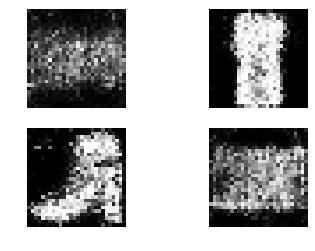

3401 [D loss: 0.595050, acc.: 67.19%] [G loss: 0.806073]
3402 [D loss: 0.638689, acc.: 65.62%] [G loss: 0.960913]
3403 [D loss: 0.643500, acc.: 64.06%] [G loss: 0.906457]
3404 [D loss: 0.649707, acc.: 53.12%] [G loss: 0.937979]
3405 [D loss: 0.600855, acc.: 73.44%] [G loss: 0.920523]
3406 [D loss: 0.599980, acc.: 68.75%] [G loss: 0.966034]
3407 [D loss: 0.673370, acc.: 62.50%] [G loss: 0.988769]
3408 [D loss: 0.641267, acc.: 56.25%] [G loss: 0.933626]
3409 [D loss: 0.623887, acc.: 65.62%] [G loss: 0.932261]
3410 [D loss: 0.686801, acc.: 65.62%] [G loss: 0.807720]
3411 [D loss: 0.612541, acc.: 73.44%] [G loss: 0.755933]
3412 [D loss: 0.614316, acc.: 70.31%] [G loss: 0.894615]
3413 [D loss: 0.624003, acc.: 65.62%] [G loss: 0.917961]
3414 [D loss: 0.701396, acc.: 54.69%] [G loss: 0.910908]
3415 [D loss: 0.646082, acc.: 65.62%] [G loss: 0.911833]
3416 [D loss: 0.632467, acc.: 67.19%] [G loss: 0.983268]
3417 [D loss: 0.605335, acc.: 68.75%] [G loss: 0.878978]
3418 [D loss: 0.664946, acc.: 6

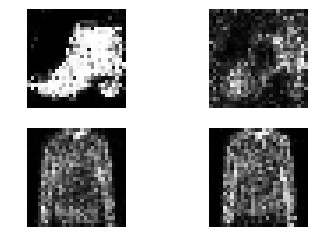

3601 [D loss: 0.700554, acc.: 54.69%] [G loss: 0.828977]
3602 [D loss: 0.655539, acc.: 59.38%] [G loss: 0.895190]
3603 [D loss: 0.574584, acc.: 73.44%] [G loss: 0.904005]
3604 [D loss: 0.659251, acc.: 62.50%] [G loss: 0.899320]
3605 [D loss: 0.630269, acc.: 67.19%] [G loss: 0.841338]
3606 [D loss: 0.658361, acc.: 60.94%] [G loss: 0.873226]
3607 [D loss: 0.651399, acc.: 62.50%] [G loss: 0.938434]
3608 [D loss: 0.644998, acc.: 57.81%] [G loss: 0.939632]
3609 [D loss: 0.639756, acc.: 59.38%] [G loss: 0.913344]
3610 [D loss: 0.629755, acc.: 71.88%] [G loss: 0.924262]
3611 [D loss: 0.619098, acc.: 68.75%] [G loss: 0.883964]
3612 [D loss: 0.622487, acc.: 62.50%] [G loss: 0.977242]
3613 [D loss: 0.623962, acc.: 64.06%] [G loss: 0.934417]
3614 [D loss: 0.626470, acc.: 64.06%] [G loss: 0.931259]
3615 [D loss: 0.676097, acc.: 54.69%] [G loss: 0.926812]
3616 [D loss: 0.725135, acc.: 48.44%] [G loss: 0.860065]
3617 [D loss: 0.656620, acc.: 56.25%] [G loss: 0.934387]
3618 [D loss: 0.645039, acc.: 6

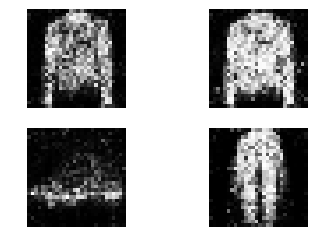

3801 [D loss: 0.650316, acc.: 60.94%] [G loss: 0.901507]
3802 [D loss: 0.701467, acc.: 53.12%] [G loss: 0.983289]
3803 [D loss: 0.681843, acc.: 51.56%] [G loss: 0.968514]
3804 [D loss: 0.677328, acc.: 56.25%] [G loss: 1.035858]
3805 [D loss: 0.646708, acc.: 57.81%] [G loss: 0.943146]
3806 [D loss: 0.632709, acc.: 64.06%] [G loss: 0.945391]
3807 [D loss: 0.731528, acc.: 48.44%] [G loss: 0.944799]
3808 [D loss: 0.671886, acc.: 60.94%] [G loss: 0.817899]
3809 [D loss: 0.611035, acc.: 64.06%] [G loss: 0.836016]
3810 [D loss: 0.640765, acc.: 67.19%] [G loss: 0.824434]
3811 [D loss: 0.697840, acc.: 53.12%] [G loss: 0.859994]
3812 [D loss: 0.617214, acc.: 64.06%] [G loss: 0.925990]
3813 [D loss: 0.676045, acc.: 60.94%] [G loss: 0.881395]
3814 [D loss: 0.662752, acc.: 56.25%] [G loss: 0.912049]
3815 [D loss: 0.640975, acc.: 65.62%] [G loss: 0.859720]
3816 [D loss: 0.646124, acc.: 62.50%] [G loss: 0.954229]
3817 [D loss: 0.650095, acc.: 57.81%] [G loss: 0.975170]
3818 [D loss: 0.685838, acc.: 5

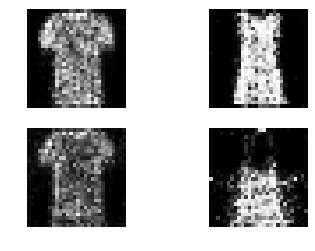

4001 [D loss: 0.626974, acc.: 67.19%] [G loss: 0.887698]
4002 [D loss: 0.608696, acc.: 75.00%] [G loss: 0.869959]
4003 [D loss: 0.655853, acc.: 57.81%] [G loss: 0.837026]
4004 [D loss: 0.651399, acc.: 68.75%] [G loss: 0.875945]
4005 [D loss: 0.638182, acc.: 60.94%] [G loss: 0.895562]
4006 [D loss: 0.616783, acc.: 65.62%] [G loss: 0.953460]
4007 [D loss: 0.658617, acc.: 59.38%] [G loss: 0.836198]
4008 [D loss: 0.625383, acc.: 62.50%] [G loss: 0.935184]
4009 [D loss: 0.656138, acc.: 65.62%] [G loss: 0.972198]
4010 [D loss: 0.656030, acc.: 60.94%] [G loss: 0.872633]
4011 [D loss: 0.674679, acc.: 59.38%] [G loss: 0.871923]
4012 [D loss: 0.655359, acc.: 64.06%] [G loss: 0.843142]
4013 [D loss: 0.694759, acc.: 56.25%] [G loss: 0.918766]
4014 [D loss: 0.609063, acc.: 62.50%] [G loss: 0.801167]
4015 [D loss: 0.635601, acc.: 65.62%] [G loss: 0.929720]
4016 [D loss: 0.654058, acc.: 56.25%] [G loss: 0.863882]
4017 [D loss: 0.714392, acc.: 59.38%] [G loss: 0.888523]
4018 [D loss: 0.620732, acc.: 6

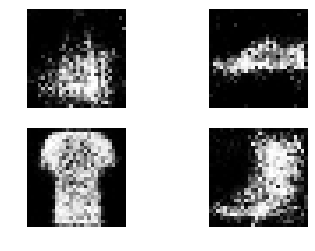

4201 [D loss: 0.687778, acc.: 59.38%] [G loss: 0.916136]
4202 [D loss: 0.660291, acc.: 59.38%] [G loss: 0.843190]
4203 [D loss: 0.592330, acc.: 68.75%] [G loss: 0.921636]
4204 [D loss: 0.694643, acc.: 65.62%] [G loss: 0.969168]
4205 [D loss: 0.675988, acc.: 54.69%] [G loss: 0.912230]
4206 [D loss: 0.624704, acc.: 65.62%] [G loss: 0.839967]
4207 [D loss: 0.715210, acc.: 48.44%] [G loss: 0.930713]
4208 [D loss: 0.666302, acc.: 60.94%] [G loss: 0.850693]
4209 [D loss: 0.600212, acc.: 70.31%] [G loss: 0.887572]
4210 [D loss: 0.639283, acc.: 64.06%] [G loss: 0.892066]
4211 [D loss: 0.637134, acc.: 62.50%] [G loss: 0.833525]
4212 [D loss: 0.666558, acc.: 59.38%] [G loss: 0.913544]
4213 [D loss: 0.652289, acc.: 56.25%] [G loss: 0.885836]
4214 [D loss: 0.551337, acc.: 81.25%] [G loss: 0.830619]
4215 [D loss: 0.674673, acc.: 56.25%] [G loss: 0.949891]
4216 [D loss: 0.630748, acc.: 60.94%] [G loss: 0.840357]
4217 [D loss: 0.634644, acc.: 60.94%] [G loss: 0.902588]
4218 [D loss: 0.657144, acc.: 6

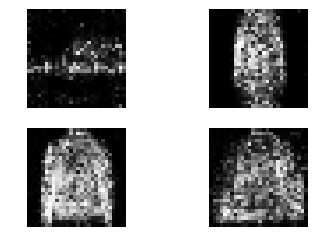

4401 [D loss: 0.656568, acc.: 67.19%] [G loss: 0.833951]
4402 [D loss: 0.607189, acc.: 68.75%] [G loss: 0.914765]
4403 [D loss: 0.623169, acc.: 62.50%] [G loss: 0.885509]
4404 [D loss: 0.553626, acc.: 75.00%] [G loss: 1.039428]
4405 [D loss: 0.642094, acc.: 71.88%] [G loss: 0.866910]
4406 [D loss: 0.614410, acc.: 57.81%] [G loss: 0.878815]
4407 [D loss: 0.665019, acc.: 60.94%] [G loss: 0.897835]
4408 [D loss: 0.639210, acc.: 64.06%] [G loss: 0.902858]
4409 [D loss: 0.643547, acc.: 62.50%] [G loss: 0.969367]
4410 [D loss: 0.639233, acc.: 67.19%] [G loss: 0.902070]
4411 [D loss: 0.697211, acc.: 50.00%] [G loss: 0.798933]
4412 [D loss: 0.654918, acc.: 67.19%] [G loss: 0.881816]
4413 [D loss: 0.632544, acc.: 60.94%] [G loss: 0.944734]
4414 [D loss: 0.613412, acc.: 64.06%] [G loss: 0.929394]
4415 [D loss: 0.599058, acc.: 64.06%] [G loss: 0.845291]
4416 [D loss: 0.638133, acc.: 70.31%] [G loss: 0.927103]
4417 [D loss: 0.681326, acc.: 53.12%] [G loss: 0.898987]
4418 [D loss: 0.663904, acc.: 5

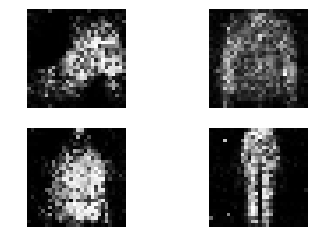

4601 [D loss: 0.663505, acc.: 65.62%] [G loss: 0.958942]
4602 [D loss: 0.668373, acc.: 56.25%] [G loss: 0.871797]
4603 [D loss: 0.721252, acc.: 54.69%] [G loss: 0.870561]
4604 [D loss: 0.676623, acc.: 65.62%] [G loss: 0.862086]
4605 [D loss: 0.672329, acc.: 57.81%] [G loss: 0.882451]
4606 [D loss: 0.674940, acc.: 62.50%] [G loss: 0.878467]
4607 [D loss: 0.617884, acc.: 71.88%] [G loss: 0.884144]
4608 [D loss: 0.748474, acc.: 56.25%] [G loss: 0.931217]
4609 [D loss: 0.643817, acc.: 68.75%] [G loss: 0.796957]
4610 [D loss: 0.586906, acc.: 76.56%] [G loss: 0.831388]
4611 [D loss: 0.649597, acc.: 65.62%] [G loss: 0.917225]
4612 [D loss: 0.665879, acc.: 54.69%] [G loss: 0.932664]
4613 [D loss: 0.589238, acc.: 70.31%] [G loss: 0.880130]
4614 [D loss: 0.665102, acc.: 57.81%] [G loss: 0.914108]
4615 [D loss: 0.617855, acc.: 62.50%] [G loss: 0.953282]
4616 [D loss: 0.609555, acc.: 70.31%] [G loss: 0.926165]
4617 [D loss: 0.618069, acc.: 70.31%] [G loss: 0.947341]
4618 [D loss: 0.677019, acc.: 5

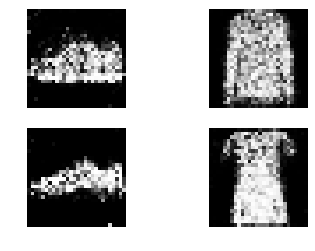

4801 [D loss: 0.677810, acc.: 53.12%] [G loss: 0.956140]
4802 [D loss: 0.597450, acc.: 68.75%] [G loss: 0.935679]
4803 [D loss: 0.653638, acc.: 53.12%] [G loss: 0.961047]
4804 [D loss: 0.688476, acc.: 60.94%] [G loss: 0.950690]
4805 [D loss: 0.593989, acc.: 70.31%] [G loss: 0.979446]
4806 [D loss: 0.736199, acc.: 45.31%] [G loss: 0.922839]
4807 [D loss: 0.623294, acc.: 71.88%] [G loss: 0.887673]
4808 [D loss: 0.665282, acc.: 50.00%] [G loss: 0.844850]
4809 [D loss: 0.622363, acc.: 73.44%] [G loss: 0.854749]
4810 [D loss: 0.676304, acc.: 59.38%] [G loss: 0.874268]
4811 [D loss: 0.645027, acc.: 59.38%] [G loss: 0.790010]
4812 [D loss: 0.660500, acc.: 68.75%] [G loss: 0.902089]
4813 [D loss: 0.650038, acc.: 59.38%] [G loss: 0.879965]
4814 [D loss: 0.616558, acc.: 62.50%] [G loss: 0.849550]
4815 [D loss: 0.595489, acc.: 67.19%] [G loss: 0.985827]
4816 [D loss: 0.612444, acc.: 65.62%] [G loss: 0.876516]
4817 [D loss: 0.681185, acc.: 50.00%] [G loss: 0.862163]
4818 [D loss: 0.595887, acc.: 6

In [15]:
gan = GAN()
gan.train(epochs=5000, batch_size=32, sample_interval=200)

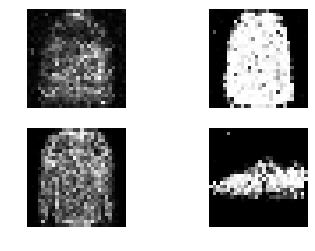

In [16]:
gan.sample_images(epoch=2)